In [22]:
%matplotlib inline

import numpy as np
import numba
import matplotlib.pylab as plt
import matplotlib.cm as cm

from read_worm import nanunwrap, _h_bend_angles

In [13]:
data = np.load('worm_example.npz')

skeletons = data['skeleton']
dorsal_contours = data['dorsal_contour']
ventral_contours = data['ventral_contour']


    

In [39]:
class DataPartition():
    def __init__(self, partitions=None, n_segments=49):
        partitions_dflt = {'head': (0, 8),
                            'neck': (8, 16),
                            'midbody': (16, 33),
                            'hips': (33, 41),
                            'tail': (41, 49),
                            'head_tip': (0, 3),
                            'head_base': (5, 8),
                            'tail_base': (41, 44),
                            'tail_tip': (46, 49),
                            'all': (0, 49),
                            'body': (8, 41)
                            }
        
        if partitions is None:
            partitions = partitions_dflt
        else:
            partitions = {p:partitions_dflt[p] for p in partitions}
            
        
        if n_segments != 49:
            r_fun = lambda x : int(round(x/49*n_segments))
            for key in partitions:
                partitions[key] = tuple(map(r_fun, partitions[key]))
        
        self.n_segments = n_segments
        self.partitions =  partitions

    def apply(self, data, partition, func, segment_axis=1):
        assert self.n_segments == data.shape[segment_axis]
        assert partition in self.partitions
        
        ini, fin = self.partitions[partition]
        sub_data = np.take(data, np.arange(ini, fin), axis=segment_axis)
        d_transform = func(sub_data, axis=segment_axis)
        
        return d_transform
   
    def apply_partitions(self, data, func, segment_axis=1):
        return {p:self.apply(data, p, func, segment_axis=segment_axis) for p in self.partitions}



(7505, 2)

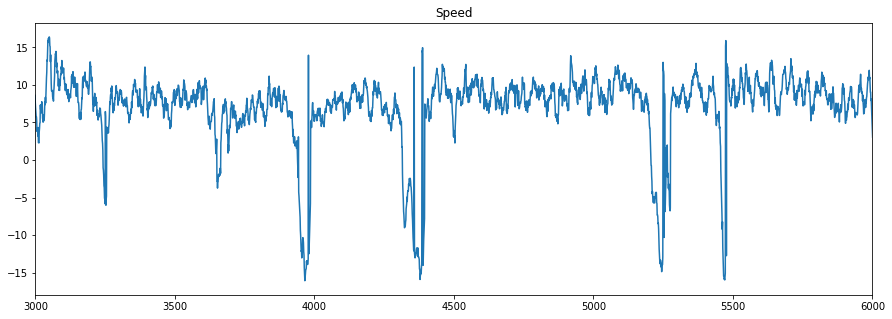

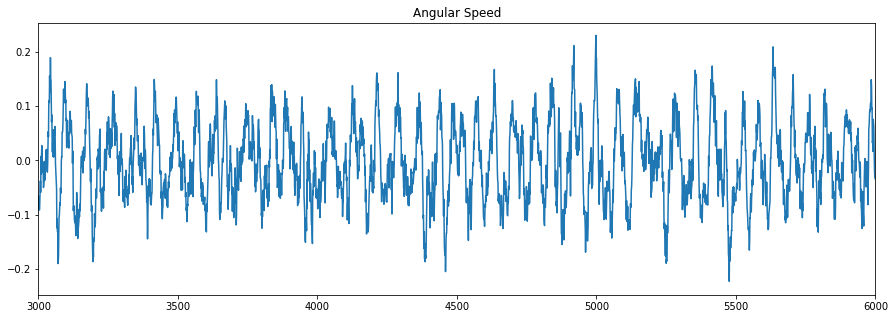

In [154]:
def _h_orientation_vector(x, axis=None):
    return x[:, 0, :] - x[:, -1, :]

valid_partitions = ['head_tip', 'head', 'neck', 'midbody', 'hips', 'tail']
p_obj = DataPartition(partitions=valid_partitions)

coords = p_obj.apply(skeletons, 'midbody', func=np.mean)
orientation_v = p_obj.apply(skeletons, 'midbody', func=_h_orientation_vector)

delta_time = 12

coords = coord_avgs['midbody']
velocity = (coords[delta_time:] - coords[:-delta_time])/delta_time
speed = np.linalg.norm(velocity, axis=1)
#I do not need to normalize the vectors because it will only add a constant factor, 
#and I am only interested in the sign
s_sign = np.sign(np.sum(velocity*orientation_v[delta_time:], axis=1))
signed_speed = speed *s_sign

#let's change the vector to angles
orientation = np.arctan2(orientation_v[:, 0], orientation_v[:, 1])
#wrap the angles so the change is continous no jump between np.pi and -np.pi
orientation = nanunwrap(orientation) 
angular_velocity = (orientation[delta_time:] - orientation[:-delta_time])/delta_time

xlim = (3000, 6000)
plt.figure(figsize = (15, 5))
plt.plot(signed_speed)
plt.title('Speed')
plt.xlim(xlim)

plt.figure(figsize = (15, 5))
plt.plot(angular_velocity)
plt.xlim(xlim)
plt.title('Angular Speed')

orientation_v.shape

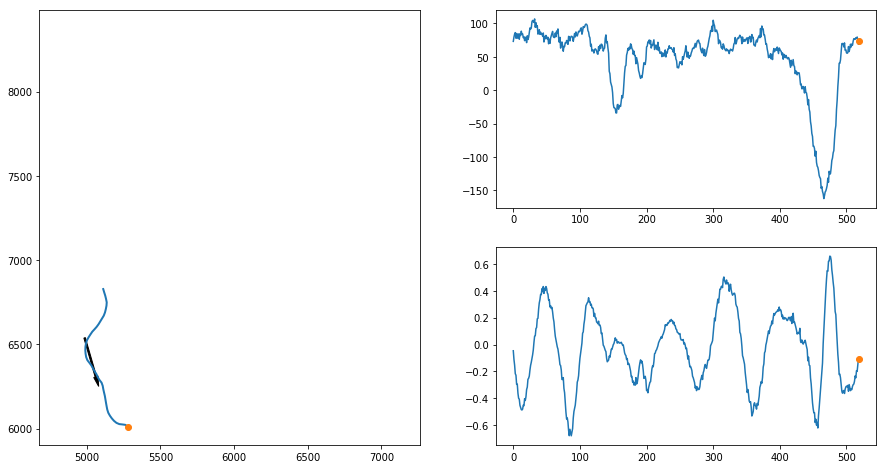

In [120]:
from matplotlib import animation, rc, patches
from IPython.display import HTML

ini_t = 3500
fin_t = 4020
skel_a = skeletons[ini_t:fin_t]

arrow_size = orientation_v[ini_t:fin_t]
ini_arrow = coords[ini_t:fin_t] - arrow_size/2

ang_v = angular_velocity[ini_t:fin_t]
speed_v = signed_speed[ini_t:fin_t]


x_range = [np.nanmin(skel_a[...,0]), np.nanmax(skel_a[...,0])]
y_range = [np.nanmin(skel_a[...,1]), np.nanmax(skel_a[...,1])]

dx, dy = np.diff(x_range), np.diff(y_range)
if dx > dy:
    y_range[1] = y_range[0] + dx
else:
    x_range[1] = x_range[0] + dy


fig = plt.figure(figsize = (15, 8))
ax = plt.subplot(1,2,1)
ax_speed = plt.subplot(2,2,2)
ax_ang_speed = plt.subplot(2,2,4)

# First set up the figure, the axis, and the plot element we want to animate
#fig, ax = plt.subplots()
ax.set_xlim(*x_range)
ax.set_ylim(*y_range)
line, = ax.plot([], [], lw=2)
head_p, = ax.plot([], [], 'o')
orient_arrow = patches.Arrow(*ini_arrow[0], *arrow_size[0], fc='k', ec='k')

ax_speed.plot(speed_v)
ax_ang_speed.plot(ang_v)

speed_p, = ax_speed.plot([], 'o') 
ang_speed_p, = ax_ang_speed.plot([],  'o') 

# animation function. This is called sequentially
def animate(i):
    global orient_arrow
    
    x = skel_a[i, :, 0]
    y = skel_a[i, :, 1]
    line.set_data(x, y)
    head_p.set_data(x[0], y[0])
    if ax.patches:
        ax.patches.remove(orient_arrow) 
    orient_arrow = patches.Arrow(*ini_arrow[i], *arrow_size[i], width=50, fc='k', ec='k')
    ax.add_patch(orient_arrow)
    
    speed_p.set_data(i, speed_v[i])
    ang_speed_p.set_data(i, ang_v[i])
    return (line, head_p, orient_arrow, speed_p, ang_speed_p)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,
                               frames=skel_a.shape[0], interval=20, blit=True);
HTML(anim.to_html5_video())


In [155]:
Rsin = np.sin(-orientation)
Rcos = np.cos(-orientation)
R = np.array(((Rcos, -Rsin), (Rsin, Rcos)))
R = np.rollaxis(R, -1, 0)
skel_c = skeletons - coords[:, None, :]

skel_new = []
for rr, skel in zip(R, skel_c):
    skel_new.append(np.dot(rr,skel.T).T)
skel_c = np.array(skel_new)

partition  = 'head_tip'
segment_coords = p_obj.apply(skel_c, 'head_tip', func=np.mean)

x = segment_coords[:, 0]
y = segment_coords[:, 1]
r = np.sqrt(x**2+y**2)
theta = nanunwrap(np.arctan2(y,x))

r_radial_velocity = (r[delta_time:] - r[:-delta_time])/delta_time
r_angular_velocity = (theta[delta_time:] - theta[:-delta_time])/delta_time


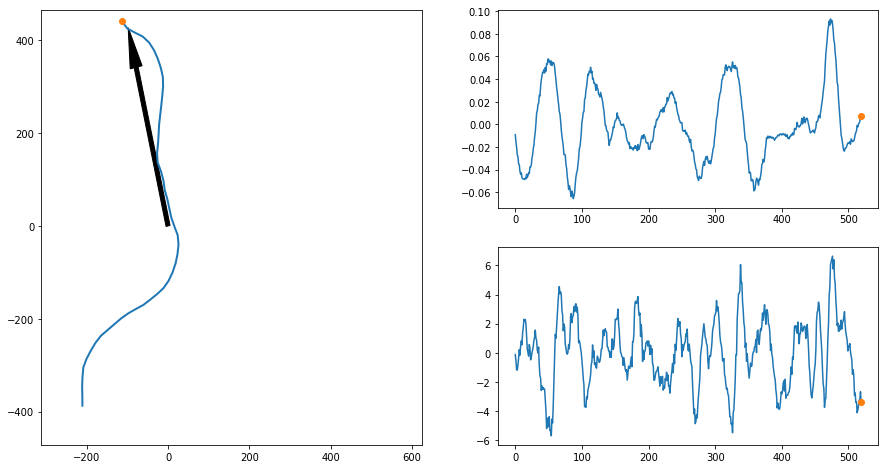

In [144]:
ini_t = 3500
fin_t = 4020
skel_a = skel_c[ini_t:fin_t]
arrow_size = segment_coords[ini_t:fin_t]
ini_arrow = np.zeros_like(arrow_size)

ang_v = angular_velocity[ini_t:fin_t]
speed_v = radial_velocity[ini_t:fin_t]


x_range = [np.nanmin(skel_a[...,0]), np.nanmax(skel_a[...,0])]
y_range = [np.nanmin(skel_a[...,1]), np.nanmax(skel_a[...,1])]

dx, dy = np.diff(x_range), np.diff(y_range)
if dx > dy:
    y_range[1] = y_range[0] + dx
else:
    x_range[1] = x_range[0] + dy

fig = plt.figure(figsize = (15, 8))
ax = plt.subplot(1,2,1)
ax_speed = plt.subplot(2,2,2)
ax_ang_speed = plt.subplot(2,2,4)

# First set up the figure, the axis, and the plot element we want to animate
#fig, ax = plt.subplots()
ax.set_xlim(*x_range)
ax.set_ylim(*y_range)
line, = ax.plot([], [], lw=2)
head_p, = ax.plot([], [], 'o')
orient_arrow = patches.Arrow(*ini_arrow[0], *arrow_size[0], fc='k', ec='k')

ax_speed.plot(speed_v)
ax_ang_speed.plot(ang_v)

speed_p, = ax_speed.plot([], 'o') 
ang_speed_p, = ax_ang_speed.plot([],  'o') 

# animation function. This is called sequentially
def animate(i):
    global orient_arrow
    
    x = skel_a[i, :, 0]
    y = skel_a[i, :, 1]
    line.set_data(x, y)
    head_p.set_data(x[0], y[0])
    if ax.patches:
        ax.patches.remove(orient_arrow) 
    orient_arrow = patches.Arrow(*ini_arrow[i], *arrow_size[i], width=50, fc='k', ec='k')
    ax.add_patch(orient_arrow)
    
    speed_p.set_data(i, speed_v[i])
    ang_speed_p.set_data(i, ang_v[i])
    return (line, head_p, orient_arrow, speed_p, ang_speed_p)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,
                               frames=skel_a.shape[0], interval=20, blit=True);
HTML(anim.to_html5_video())

(3000, 4000)

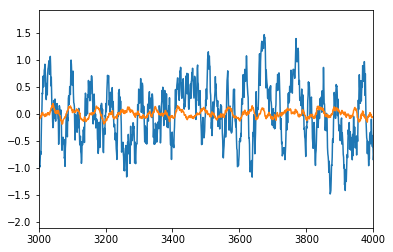

In [156]:
plt.plot(r_angular_velocity)
plt.plot(angular_velocity)
plt.xlim((3000, 4000))


/Users/ajaver/Documents/GitHub/work-in-progress/work_in_progress/new_features/read_worm.py:155: RuntimeWarning: invalid value encountered in greater
  ang[ang > np.pi] -= 2 * np.pi
/Users/ajaver/Documents/GitHub/work-in-progress/work_in_progress/new_features/read_worm.py:156: RuntimeWarning: invalid value encountered in less
  ang[ang < -np.pi] += 2 * np.pi


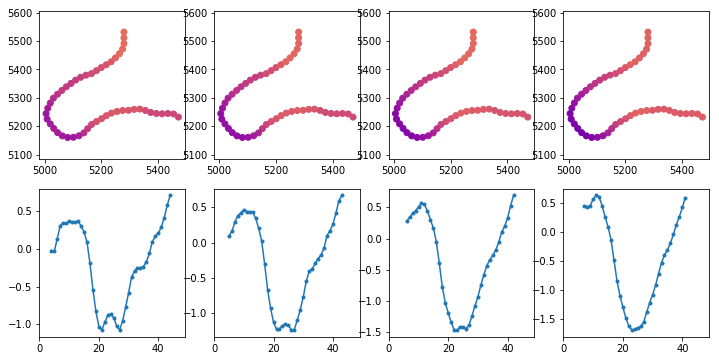

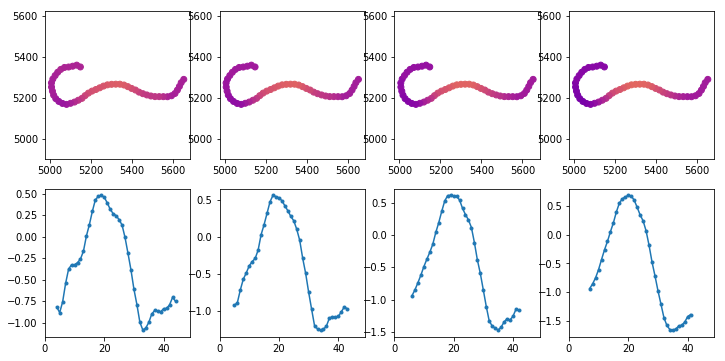

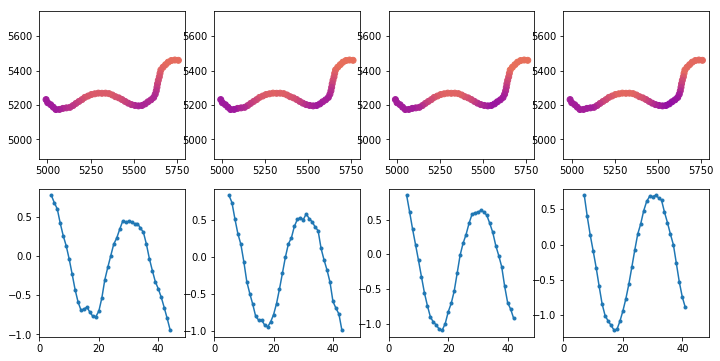

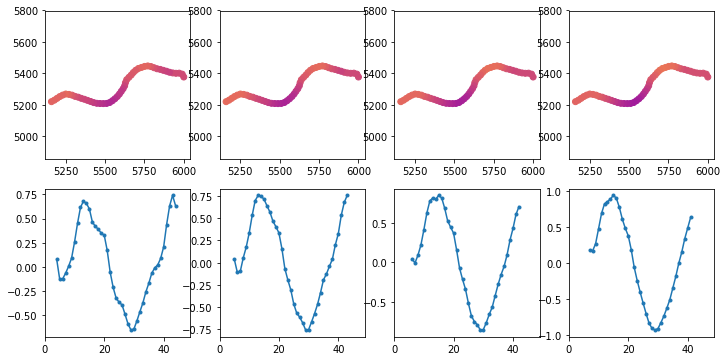

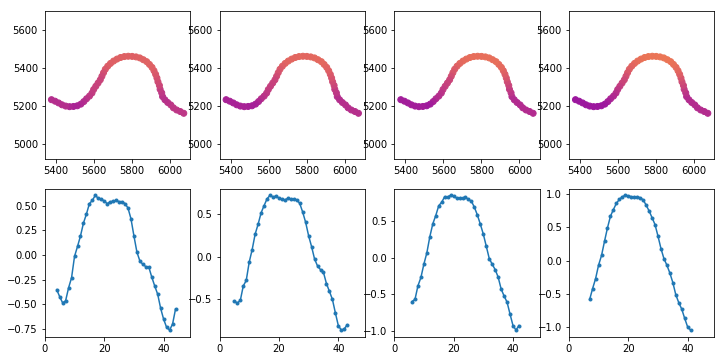

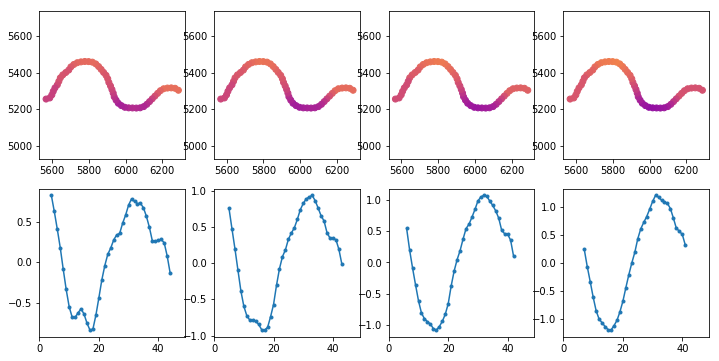

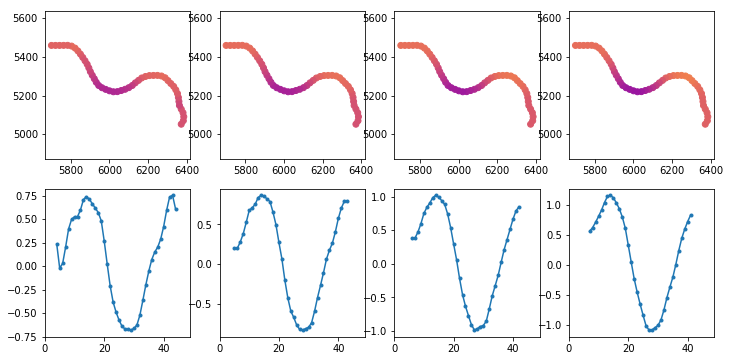

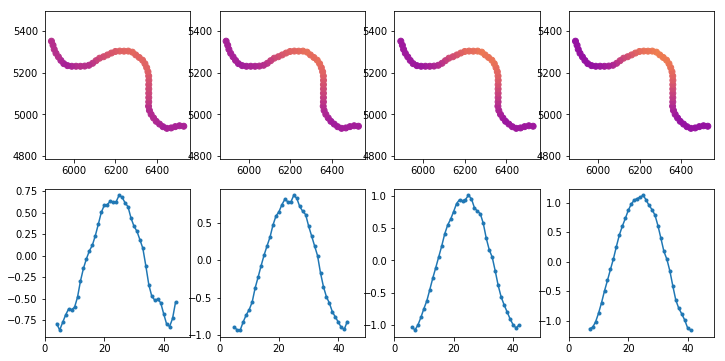

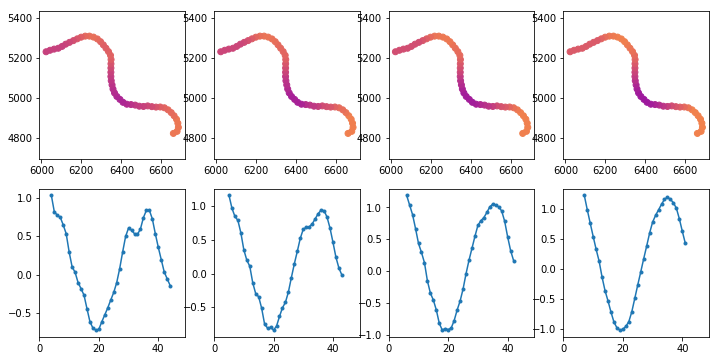

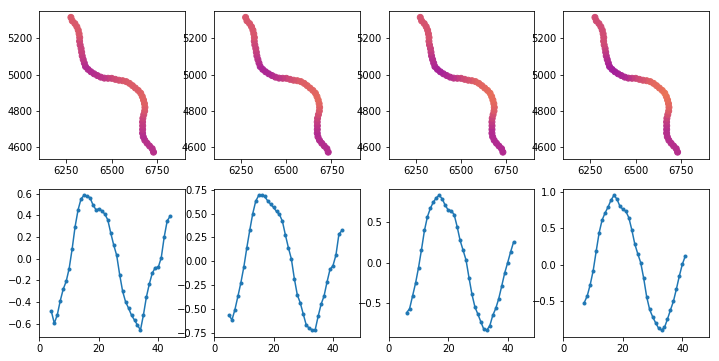

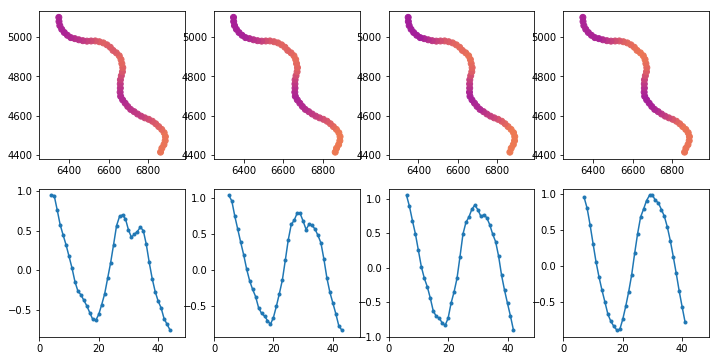

In [23]:
angles = [(segment_size, _h_bend_angles(skeletons, segment_size)) for segment_size in  range(4,8)]

tot = len(angles)
n_cols = tot
n_rows = 2#int(np.ceil(tot/n_cols))
segment_size, ang = angles[2]

n_range = 301
start_p = 7000
delta_f = 30
for ii in range(start_p, start_p+n_range, delta_f):
    plt.figure(figsize=(3*n_cols,3*n_rows))

    for iseg, (segment_size, ang) in enumerate(angles):
        plt.subplot(2, n_cols, iseg+1)
        x = skeletons[ii,:,0]
        y = skeletons[ii,:,1]
        c = (ang[ii]+np.pi)/(2*np.pi)
        c = np.pad(c, (segment_size,segment_size), 'edge')
        c = cm.plasma(c)
        plt.scatter(x, y, c=c)
        plt.axis('equal')


        plt.subplot(2,n_cols, iseg+1+n_cols)
        dd = np.arange(ang[ii].size) + segment_size
        plt.plot(dd, ang[ii], '.-')

        plt.xlim(0, x.size)